In [1]:
import copy
import matplotlib.patches as patches
import Metrica_Viz as mviz
import Metrica_IO as mio
import numpy as np
import pandas as pd
import warnings
from preprocessing import PreProcessing
from cmap import Colormap
from imblearn.over_sampling import SMOTE, RandomOverSampler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, KMeans, SpectralClustering
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing(data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
                           data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv")
game_1_data = game_1_pre.load_and_process_data(add_ball_data=False, half_period="both")

In [3]:
game_2_pre = PreProcessing(data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
                           data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv")
game_2_data = game_2_pre.load_and_process_data(add_ball_data=False, half_period="both")

In [4]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player20-x,Away-Player20-y,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y
1,1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383
2,1,2,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383
3,1,3,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383
4,1,4,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55974,0.67776,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473
5,1,5,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55992,0.67791,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2,145002,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.14913,0.56230,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371
145003,2,145003,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.14937,0.56218,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283
145004,2,145004,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.14926,0.56204,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254
145005,2,145005,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.14857,0.56068,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243


In [5]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player20-x,Away-Player20-y,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y
1,1,1,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
2,1,2,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
3,1,3,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
4,1,4,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
5,1,5,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.39812,0.47218,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,141152,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.25594,0.38425,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496
141153,2,141153,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.25594,0.38425,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496
141154,2,141154,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.25594,0.38425,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496
141155,2,141155,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.25594,0.38425,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496


## Tracking for individual Players for the First Period

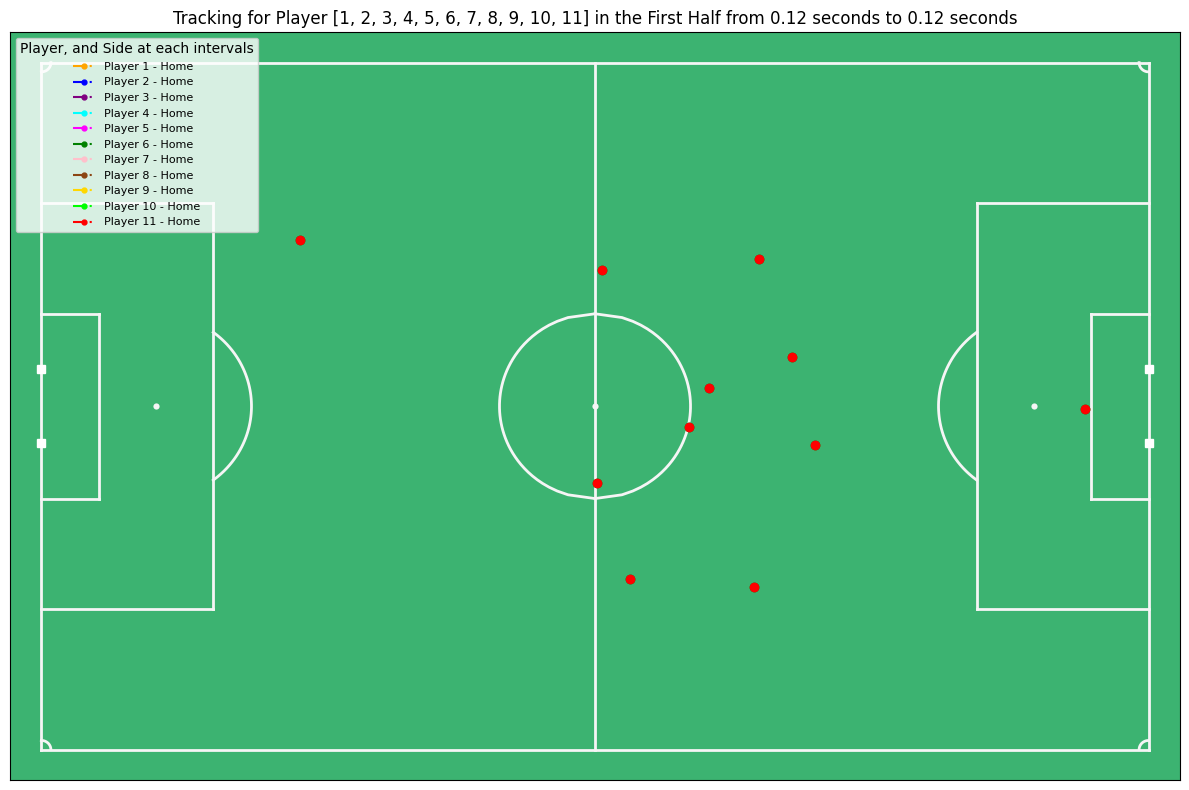

In [6]:
game_2_pre.player_tracking(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [7]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Grouping players time interval on 1 second interval

In [8]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player20-x,Away-Player20-y,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y
1,1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383
2,1,2,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383
3,1,3,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55960,0.67775,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383
4,1,4,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55974,0.67776,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473
5,1,5,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55992,0.67791,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2,145002,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.14913,0.56230,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371
145003,2,145003,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.14937,0.56218,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283
145004,2,145004,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.14926,0.56204,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254
145005,2,145005,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.14857,0.56068,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243


In [9]:
def vel_acc(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the velocity and acceleration of players and ball in a given dataset.
    
    Parameters:
    dataset (pandas.DataFrame): The input dataset containing player and ball positions over time.
    
    Returns:
    pandas.DataFrame: The original dataset with additional columns for velocity and acceleration.
    """
    temp_data = copy.deepcopy(dataset)
    star_idx = temp_data.columns.get_loc("Time [s]")
    player_columns = temp_data.columns[star_idx + 1:]

    for i in range(0, player_columns.shape[0] - 1, 2):
        # Calculate Euclidean distance between consecutive points
        ply_x, ply_y = player_columns[i], player_columns[i + 1]

        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        
        # Calculate time difference between frames
        time_diff = temp_data["Time [s]"].diff()
        
        # Calculate velocity (distance travelled / time)
        vx = x_diff / time_diff
        vy = y_diff / time_diff
        velocity = np.sqrt(vx**2 + vy**2)
        
        # Calculate acceleration (change in velocity / time)
        ax = vx.diff() / time_diff
        ay = vy.diff() / time_diff
        acceleration = np.sqrt(ax**2 + ay**2)
        
        if "Ball" in ply_x:
            temp_data[f"ball_velocity"] = velocity
            temp_data[f"ball_acceleration"] = acceleration
        else:
            players_num = ply_x[11]
            if len(ply_x) == 15:
                players_num = ply_x[11:13]
                
            temp_data[f"P_{players_num}_velocity"] = velocity
            temp_data[f"P_{players_num}_acceleration"] = acceleration
    
    return temp_data

In [10]:
def get_frames(dataset: pd.DataFrame, players: list[int], frame: int, frame_interval: int = 5000) -> pd.DataFrame:
    start_range = dataset.index[0] if frame - frame_interval < dataset.index[0] else frame - frame_interval
    end_range = (dataset.index[-1] if frame + frame_interval > dataset.index[-1] else frame + frame_interval) + 1
    
    index = pd.RangeIndex(start=start_range, stop=end_range, step=1)
    temp_data = pd.DataFrame(index=index)
    # temp_data["Time[s]"] = dataset["Time[s]"]

    for i in players:
        players_num = i[11]
        if len(i) == 15:
            players_num = i[11:13]
        players_num = int(players_num)
        
        if int(players_num) < 15:
            # The index is the same as frames
            temp_data[f"Home-Player{players_num}-x"] = dataset.loc[start_range:end_range, f"Home-Player{players_num}-x"]
            temp_data[f"Home-Player{players_num}-y"] = dataset.loc[start_range:end_range, f"Home-Player{players_num}-y"]
        else:
            # The index is the same as frames
            temp_data[f"Away-Player{players_num}-x"] = dataset.loc[start_range:end_range, f"Away-Player{players_num}-x"]
            temp_data[f"Away-Player{players_num}-y"] = dataset.loc[start_range:end_range, f"Away-Player{players_num}-y"]

        temp_data[f"P_{players_num}_velocity"] = dataset.loc[start_range:end_range, f"P_{players_num}_velocity"]
        temp_data[f"P_{players_num}_acceleration"] = dataset.loc[start_range:end_range, f"P_{players_num}_acceleration"]
        
    return temp_data

# Tracking players closest to the ball using frames

In [11]:
vel_acc_game_1_data = vel_acc(game_1_data)
vel_acc_game_2_data = vel_acc(game_2_data)

In [12]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_20_velocity,P_20_acceleration,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration
1,1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
3,1,3,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,4,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.003509,0.087723,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275
5,1,5,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.005858,0.091001,0.008515,0.333366,0.011560,0.190804,0.022103,0.613456,0.029100,0.160078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2,145002,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.008976,0.166419,0.010198,0.168170,0.002704,0.057622,0.013613,0.050389,0.017509,0.084085
145003,2,145003,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.006708,0.073154,0.004031,0.162500,0.011319,0.245029,0.014346,0.025000,0.022407,0.122793
145004,2,145004,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.004451,0.219107,0.009394,0.225000,0.007906,0.213783,0.013829,0.013975,0.009100,0.370072
145005,2,145005,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.038126,0.844282,0.013500,0.160078,0.013440,0.143886,0.015004,0.188953,0.007754,0.120708


In [13]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_20_velocity,P_20_acceleration,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration
1,1,1,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,NaN,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN
3,1,3,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,1,4,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,1,5,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,141152,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.0,0.0,0.00875,0.06250,0.010000,0.038017,0.0,0.0,0.0,0.0
141153,2,141153,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.0,0.0,0.00975,0.02500,0.006951,0.076291,0.0,0.0,0.0,0.0
141154,2,141154,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.0,0.0,0.00700,0.06875,0.016623,0.269403,0.0,0.0,0.0,0.0
141155,2,141155,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.0,0.0,0.00925,0.05625,0.009014,0.594933,0.0,0.0,0.0,0.0


In [14]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [15]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_20_velocity,P_20_acceleration,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,NaN,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,0.0,0.00875,0.06250,0.010000,0.038017,0.0,0.0,0.0,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,0.0,0.00975,0.02500,0.006951,0.076291,0.0,0.0,0.0,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,0.0,0.00700,0.06875,0.016623,0.269403,0.0,0.0,0.0,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.0,0.0,0.00925,0.05625,0.009014,0.594933,0.0,0.0,0.0,0.0


In [16]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [17]:
game_1_player_data = get_frames(game_1_ply_tra, players=game_1_ply_tra.columns[0:44:2], frame=1000000, frame_interval=1000000).fillna(0)
game_2_player_data = get_frames(game_2_ply_tra, players=game_2_ply_tra.columns[0:44:2], frame=1000000, frame_interval=1000000).fillna(0)

In [18]:
game_2_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_22_velocity,P_22_acceleration,Away-Player23-x,Away-Player23-y,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration
1,0.94275,0.50413,0.0,0.0,0.64812,0.28605,0.0,0.0,0.67752,0.42803,...,0.000000,0.000000,0.50177,0.50145,0.0,0.0,0.49517,0.36234,0.0,0.0
2,0.94275,0.50413,0.0,0.0,0.64812,0.28605,0.0,0.0,0.67752,0.42803,...,0.000000,0.000000,0.50177,0.50145,0.0,0.0,0.49517,0.36234,0.0,0.0
3,0.94275,0.50413,0.0,0.0,0.64812,0.28605,0.0,0.0,0.67752,0.42803,...,0.000000,0.000000,0.50177,0.50145,0.0,0.0,0.49517,0.36234,0.0,0.0
4,0.94275,0.50413,0.0,0.0,0.64812,0.28605,0.0,0.0,0.67752,0.42803,...,0.000000,0.000000,0.50177,0.50145,0.0,0.0,0.49517,0.36234,0.0,0.0
5,0.94275,0.50413,0.0,0.0,0.64812,0.28605,0.0,0.0,0.67752,0.42803,...,0.000000,0.000000,0.50177,0.50145,0.0,0.0,0.49517,0.36234,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.0,0.0,0.38499,0.15356,0.0,0.0,0.22558,0.41355,...,0.010000,0.038017,0.26855,0.61845,0.0,0.0,0.36760,0.12496,0.0,0.0
141153,0.06285,0.51243,0.0,0.0,0.38499,0.15356,0.0,0.0,0.22558,0.41355,...,0.006951,0.076291,0.26855,0.61845,0.0,0.0,0.36760,0.12496,0.0,0.0
141154,0.06285,0.51243,0.0,0.0,0.38499,0.15356,0.0,0.0,0.22558,0.41355,...,0.016623,0.269403,0.26855,0.61845,0.0,0.0,0.36760,0.12496,0.0,0.0
141155,0.06285,0.51243,0.0,0.0,0.38499,0.15356,0.0,0.0,0.22558,0.41355,...,0.009014,0.594933,0.26855,0.61845,0.0,0.0,0.36760,0.12496,0.0,0.0


# Classification

In [19]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [20]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [21]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [22]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [23]:
game_1_event_data.sample(5)

,Type,Start Frame,End Frame,From,To
539,CHALLENGE,43455,43455,Player22,NaN
1646,PASS,134012,134020,Player17,Player28
1737,BALL LOST,143229,143247,Player18,NaN
259,RECOVERY,19616,19616,Player20,NaN
310,PASS,23146,23174,Player21,Player20


In [24]:
start_frames = np.array(game_1_event_data["Start Frame"].iloc[1:])
end_frames = np.array(game_1_event_data["End Frame"].iloc[1:])

assert start_frames.shape == end_frames.shape
frame_ranges = [np.sort(np.array([i, j])) for i, j in zip(end_frames, start_frames)]

game_1_event = pd.DataFrame(columns=["Type"])
end = game_1_player_data.index[-1]
for i, f in enumerate(frame_ranges):
    e = (f[1] if end > f[1] else end) + 1
    for j in range(f[0], e):
        game_1_event.loc[j, "Type"] =  game_1_event_data.loc[i + 1, "Type"]
        # game_1_event.loc[j, "From"] =  game_1_event_data.loc[i + 1, "From"]
        # game_1_event.loc[j, "To"] =  game_1_event_data.loc[i + 1, "To"]
        
game_1_event = game_1_event.fillna("")

In [25]:
start_frames = np.array(game_2_event_data["Start Frame"].iloc[1:])
end_frames = np.array(game_2_event_data["End Frame"].iloc[1:])

assert start_frames.shape == end_frames.shape
frame_ranges = [np.sort(np.array([i, j])) for i, j in zip(end_frames, start_frames)]

game_2_event = pd.DataFrame(columns=["Type"])
end = game_2_player_data.index[-1]
for i, f in enumerate(frame_ranges):
    e = (f[1] if end > f[1] else end) + 1
    for j in range(f[0], e):
        game_2_event.loc[j, "Type"] =  game_2_event_data.loc[i + 1, "Type"]
        # game_2_event.loc[j, "From"] =  game_2_event_data.loc[i + 1, "From"]
        # game_2_event.loc[j, "To"] =  game_2_event_data.loc[i + 1, "To"]

game_2_event = game_2_event.fillna("")

In [26]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143626,BALL OUT
143627,BALL OUT
143628,BALL OUT
143629,BALL OUT


In [27]:
game_2_event

,Type
51,PASS
52,PASS
53,PASS
54,PASS
55,PASS
...,...
140294,BALL OUT
140295,BALL OUT
140296,BALL OUT
140297,BALL OUT


In [42]:
X_1 = game_1_player_data.loc[game_1_event.index]
y_1 = np.array(game_1_event["Type"])

In [43]:
X_2 = game_2_player_data.loc[game_2_event.index]
y_2 = np.array(game_2_event["Type"])

In [44]:
X = pd.concat([X_1, X_2])
y = np.concatenate((y_1, y_2))

assert X.shape[0] == y.shape[0]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# vectorizer = CountVectorizer()
# vectorizer.fit(y_train.ravel())
# y_train = vectorizer.transform(y_train.ravel())
# y_test = vectorizer.transform(y_test.ravel())
# y_train = y_train.toarray()
# y_test = y_test.toarray()

In [48]:
np.unique(y, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'FAULT RECEIVED',
        'PASS', 'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([17449,  5325,    10,   276,    40, 60716,   238,    21,  1162],
       dtype=int64))

In [49]:
np.unique(y_train, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'FAULT RECEIVED',
        'PASS', 'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([14011,  4275,    10,   227,    28, 48524,   177,    15,   922],
       dtype=int64))

In [50]:
np.unique(y_test, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CHALLENGE', 'FAULT RECEIVED', 'PASS',
        'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([ 3438,  1050,    49,    12, 12192,    61,     6,   240],
       dtype=int64))

In [51]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

In [52]:
np.unique(y, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'FAULT RECEIVED',
        'PASS', 'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([17449,  5325,    10,   276,    40, 60716,   238,    21,  1162],
       dtype=int64))

In [53]:
np.unique(y_train, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'FAULT RECEIVED',
        'PASS', 'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([48524, 48524, 48524, 48524, 48524, 48524, 48524, 48524, 48524],
       dtype=int64))

In [54]:
np.unique(y_test, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CHALLENGE', 'FAULT RECEIVED', 'PASS',
        'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([12192, 12192, 12192, 12192, 12192, 12192, 12192, 12192],
       dtype=int64))

In [56]:
warnings.filterwarnings("always")

In [65]:
def conf_matrix(y_train, y_train_pred, y_test, y_pred, labels, model_name=""):
    fig, ax = plt.subplots(figsize=(15, 8))
    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    ax.set_title(f"{model_name.title()} Confusion Matrix")
    disp.plot(xticks_rotation="vertical", ax=ax)
    plt.tight_layout()
    plt.show()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    precision = precision_score(y_test, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_test, y_pred, average="macro", zero_division=0)

    print(f"{model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    
    print(f"{model_name} testing accuracy: {test_accuracy * 100:0.2f}%")
    print(f"{model_name} testing f1: {f1 * 100:0.2f}%")
    print(f"{model_name} testing precision: {precision * 100:0.2f}%")
    print(f"{model_name} testing recall: {recall * 100:0.2f}%\n\n\n")
   

In [58]:
models = {
          "AdaBoost classifier": AdaBoostClassifier(random_state=42), 
          "Logistic regression": LogisticRegression(solver="saga", random_state=42),
          "Gaussian naive bayes": GaussianNB(),
          "Neural network": MLPClassifier(random_state=42), 
          "Random forest classifier": RandomForestClassifier(random_state=42), 
          # "SVM classifier": SVC(kernel="rbf", C=10, random_state=42),
         }

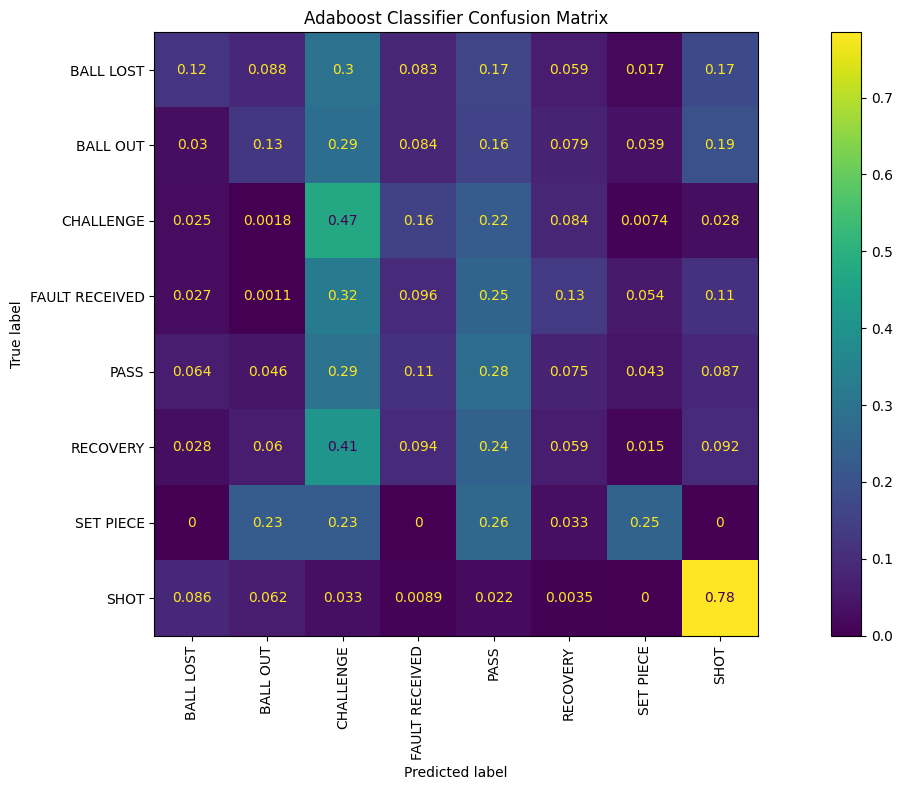

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoost classifier training accuracy: 44.23%
AdaBoost classifier testing accuracy: 24.85%
AdaBoost classifier testing f1: 21.02%
AdaBoost classifier testing precision: 25.18%
AdaBoost classifier testing recall: 22.09%





C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


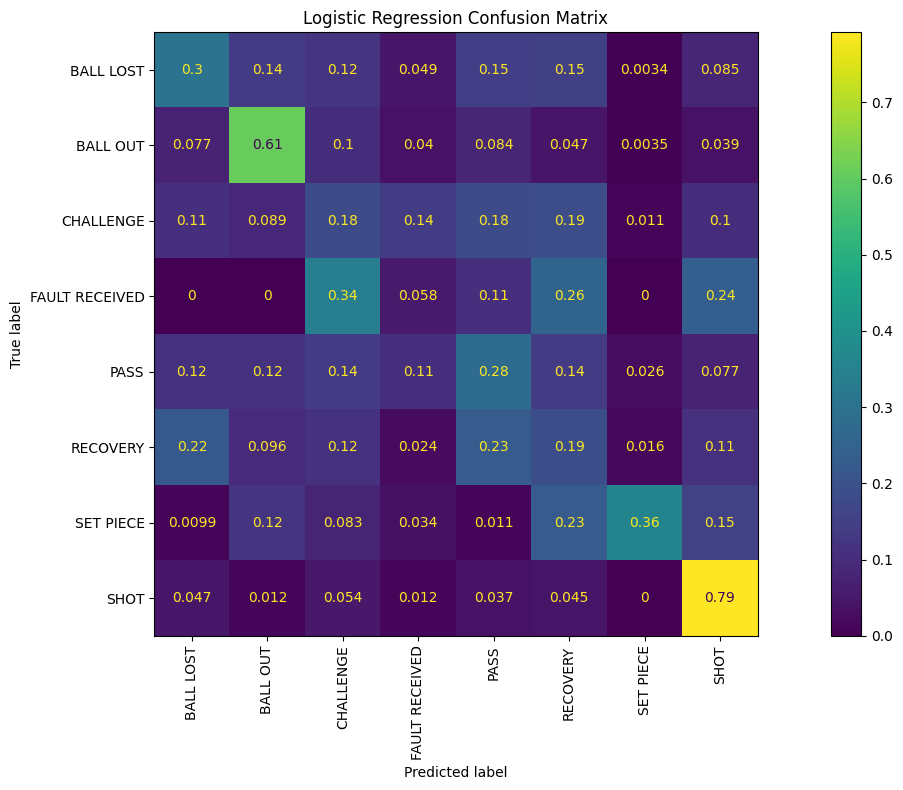

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic regression training accuracy: 64.64%
Logistic regression testing accuracy: 34.48%
Logistic regression testing f1: 29.74%
Logistic regression testing precision: 32.32%
Logistic regression testing recall: 30.65%





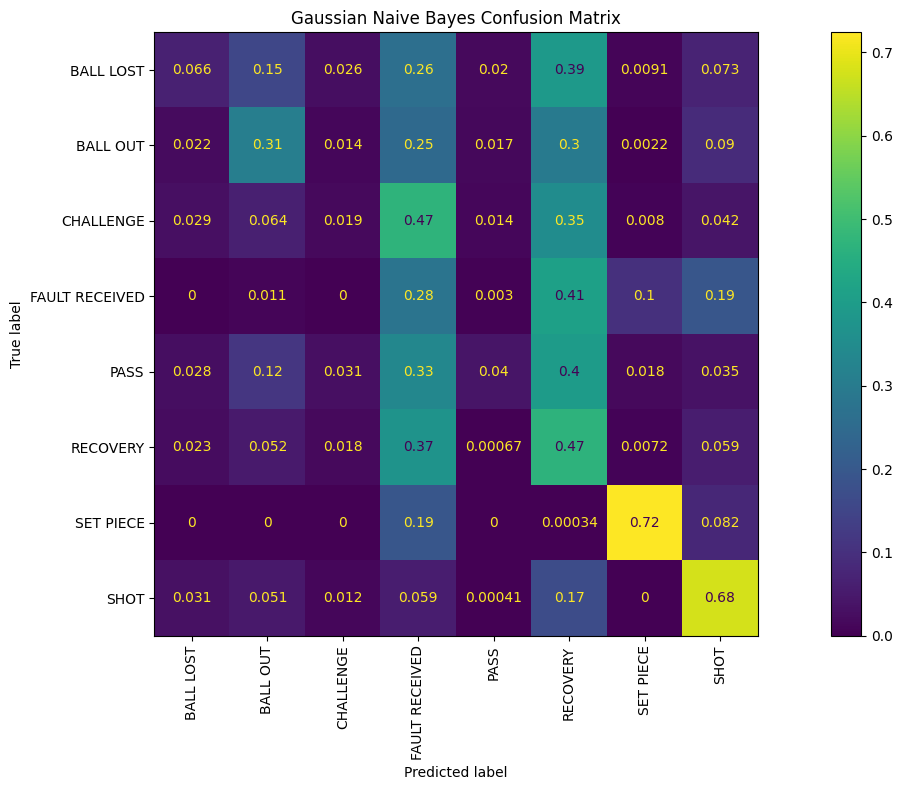

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gaussian naive bayes training accuracy: 49.60%
Gaussian naive bayes testing accuracy: 31.43%
Gaussian naive bayes testing f1: 26.22%
Gaussian naive bayes testing precision: 33.51%
Gaussian naive bayes testing recall: 27.94%





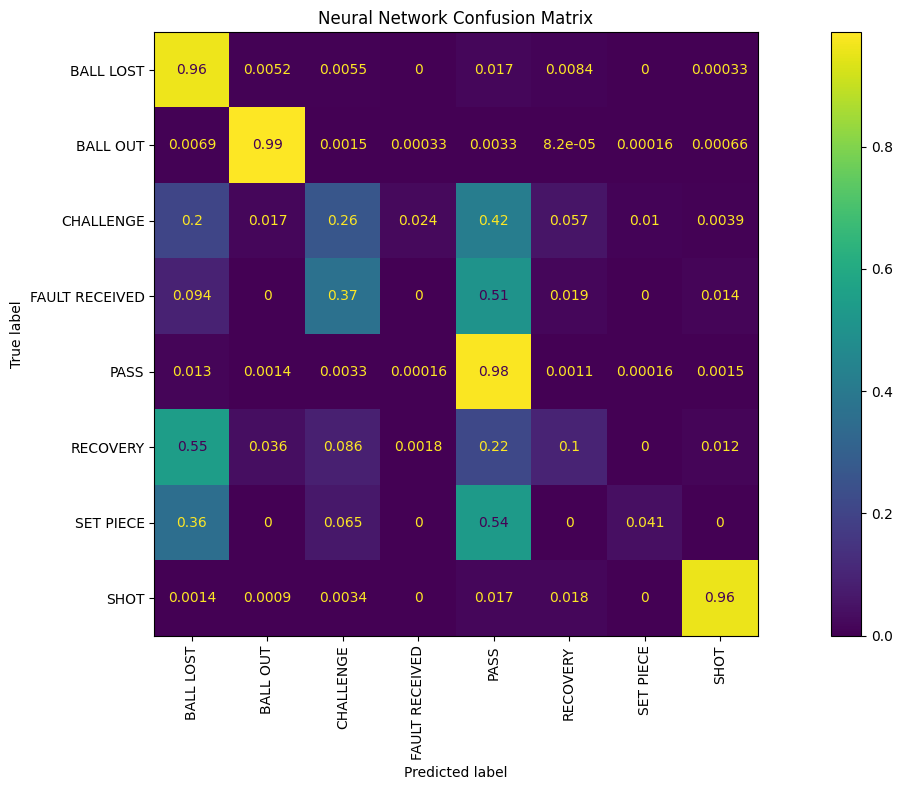

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural network training accuracy: 99.86%
Neural network testing accuracy: 53.66%
Neural network testing f1: 40.13%
Neural network testing precision: 48.35%
Neural network testing recall: 47.70%





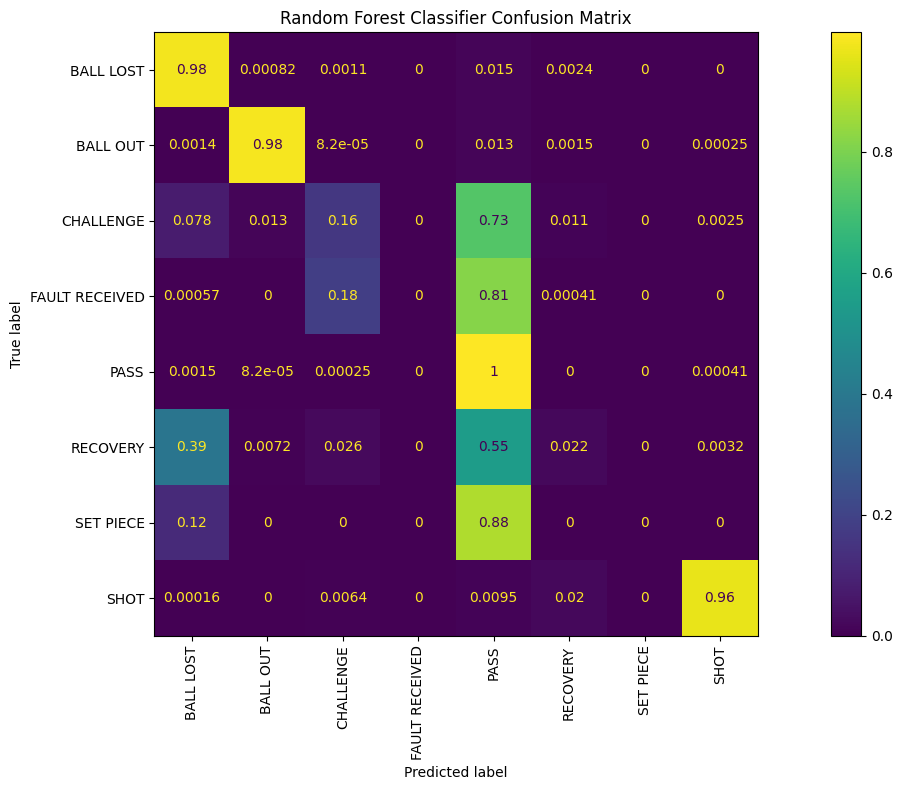

C:\Users\noill\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 51.41%
Random forest classifier testing f1: 42.50%
Random forest classifier testing precision: 45.76%
Random forest classifier testing recall: 51.41%





In [59]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    labels = np.unique(y_test)
    conf_matrix(y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_pred=y_pred, labels=labels, model_name=name)